## Exploring Gaussian Mixture Models: Applications and Limitations in Clustering

#### Asad Safarov
#### Hildebrand Austin Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin


### Introduction

The objective of this assignment is to explore the Gaussian Mixture Model (GMM), its applications, hyperparameter tuning, and limitations. It is a clustering algorithm that utilizes probability distributions to model the 

underlying structure of the data in contrast to other clustering algorithms like K-means or DBSCAN. Therefore, it is more beneficial to identify complex cluster structures in dataset. Before exploring the application of GMM, 

let us dive into the sample data set.

### Importing data 

The facies dataset is generated using the **make_nonlinear_facies.ipynb** script with seed 3124. The dataset includes 1,100 samples and contains three variables: porosity (Por), permeability (Perm), and facies (Facies).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("https://raw.githubusercontent.com/BigMiwka/Gausian-Mixture-Model/main/nonlinear_facies_3124.csv")

print("🔍 Data Summary:")
print(df.describe())
print("\n🎯 Facies Distribution:")
print(df['Facies'].value_counts())

🔍 Data Summary:
        Unnamed: 0          Por         Perm       Facies
count  1100.000000  1100.000000  1100.000000  1100.000000
mean    204.045455    13.702170   963.013196     1.727273
std     133.694775     5.439921   192.128755     0.749997
min       0.000000     0.000000    10.000000     1.000000
25%      91.000000    10.032091   869.861689     1.000000
50%     183.000000    12.827122  1009.140374     2.000000
75%     312.000000    18.124733  1099.218136     2.000000
max     499.000000    30.000000  1200.000000     3.000000

🎯 Facies Distribution:
Facies
1    500
2    400
3    200
Name: count, dtype: int64


### Data Exploration
#### Visualization of sample points based on their class

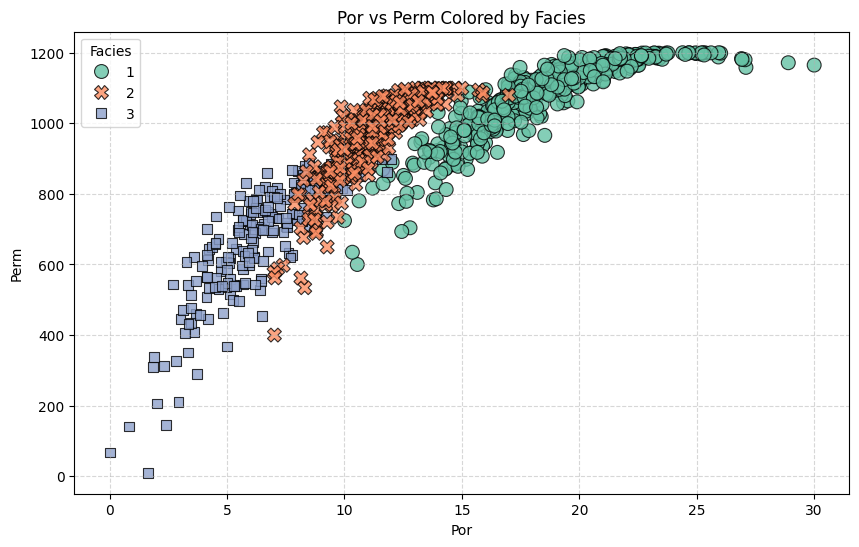

In [2]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='Por', y='Perm', hue='Facies', style='Facies',
    s=100, alpha=0.8, edgecolor='black', palette='Set2'
)
plt.title("Por vs Perm Colored by Facies")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Facies have elliptical shapes

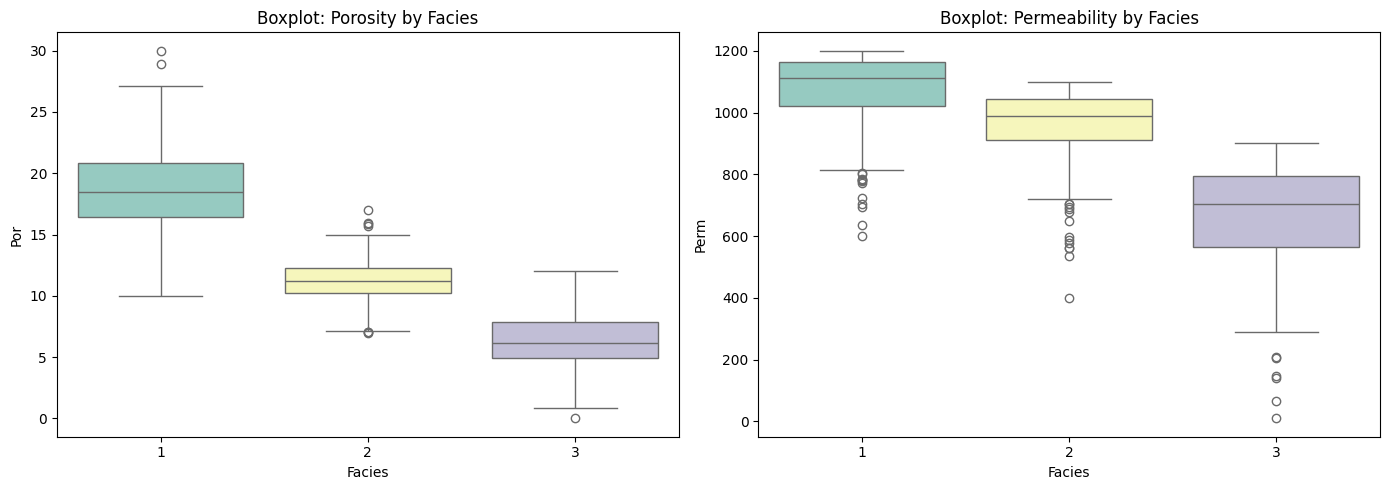

In [3]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Facies', y='Por', hue='Facies', palette='Set3', legend=False)
plt.title('Boxplot: Porosity by Facies')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Facies', y='Perm', hue='Facies', palette='Set3', legend=False)
plt.title('Boxplot: Permeability by Facies')
plt.tight_layout()
plt.show()

#### Distribution of features

##### Histograms for each feature

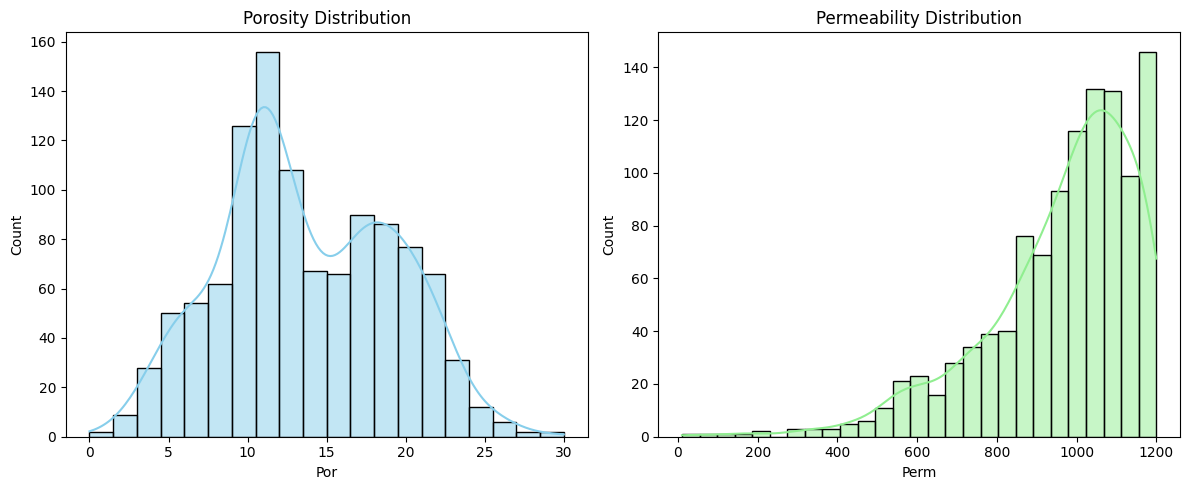

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Por'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Porosity Distribution')

sns.histplot(df['Perm'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Permeability Distribution')
plt.tight_layout()
plt.show()


Permeability feature has a skewed distribution

##### Distribution plots with KDE and Facies

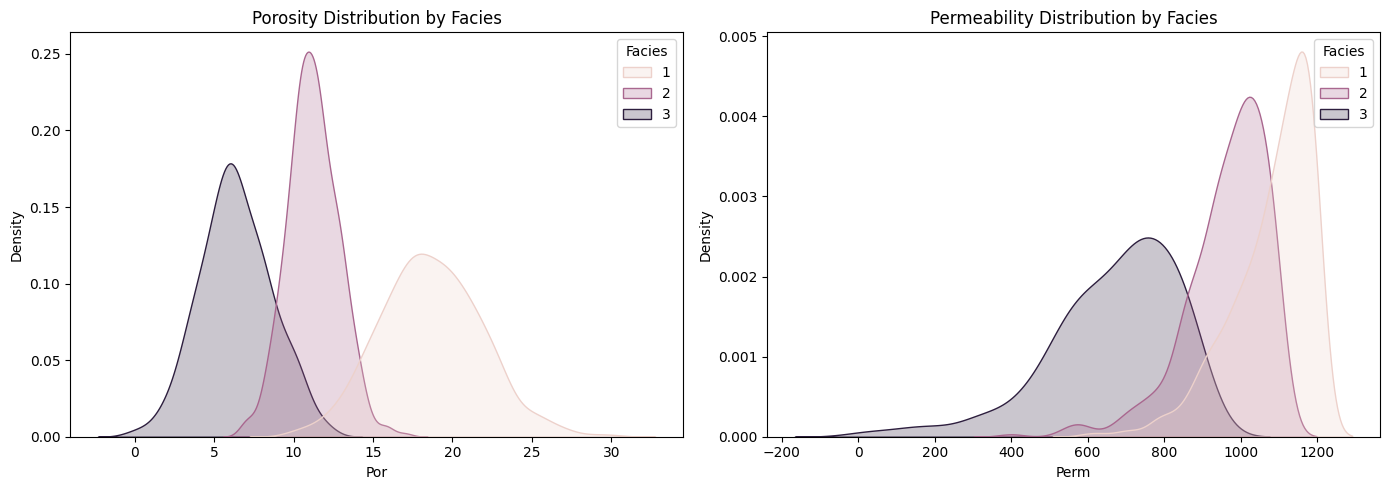

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(data=df, x='Por', hue='Facies', fill=True, common_norm=False, ax=axes[0])
axes[0].set_title('Porosity Distribution by Facies')

sns.kdeplot(data=df, x='Perm', hue='Facies', fill=True, common_norm=False, ax=axes[1])
axes[1].set_title('Permeability Distribution by Facies')

plt.tight_layout()
plt.show()

##### Bivariate KDE plot with facies hue

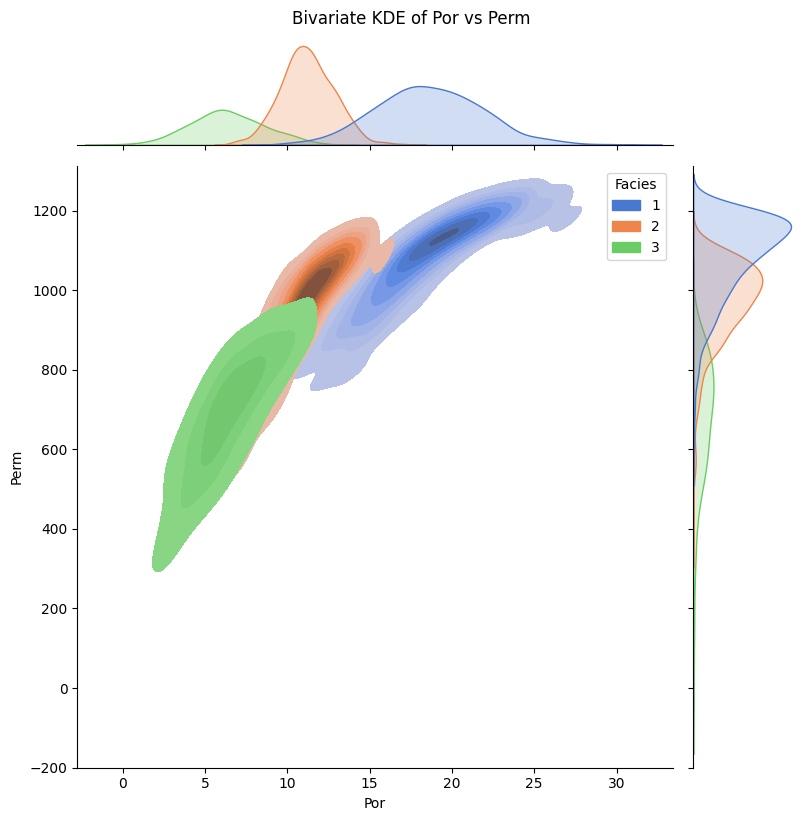

In [6]:
sns.jointplot(
    data=df, x='Por', y='Perm', hue='Facies',
    kind='kde', fill=True, palette='muted', height=8
).fig.suptitle("Bivariate KDE of Por vs Perm", y=1.02)
plt.show()

### Data Preprocessing

##### Logarithmic transformation of permeability and standardization of both features

We will train a Gaussian Mixture Model (GMM), which uses a combination of multivariate Gaussians to model data. Therefore, it is recommended to use standardized features. A mean 

vector with a covariance matrix describes each Gaussian, and the likelihood that a point belongs to a component depends on how closely it resembles the Gaussian's mean (in a 

multivariate sense). Larger-scale features will be given more weight by GMMs if the features are on different scales.  By standardizing, all features are placed on the same 

scale (mean = 0, std = 1). Additionally, the covariance matrix may become numerically unstable if the features have widely different scales, which could prevent the appropriate 

convergence of the Expectation-Maximization (EM) approach, which is used to fit GMMs.


Additionally, a logarithmic transformation is applied to the 'Perm' feature to address its skewed distribution. Given the highly skewed distribution of the feature, using 

z-score outlier detection directly may be confusing because the skew also affects the mean and standard deviation.  By decreasing skewness, a log transformation improves the 

distribution's symmetry and brings it closer to normal. Standardization is more consistent following the log transformation, which makes it possible to determine outliers 

using z-score method more precisely.

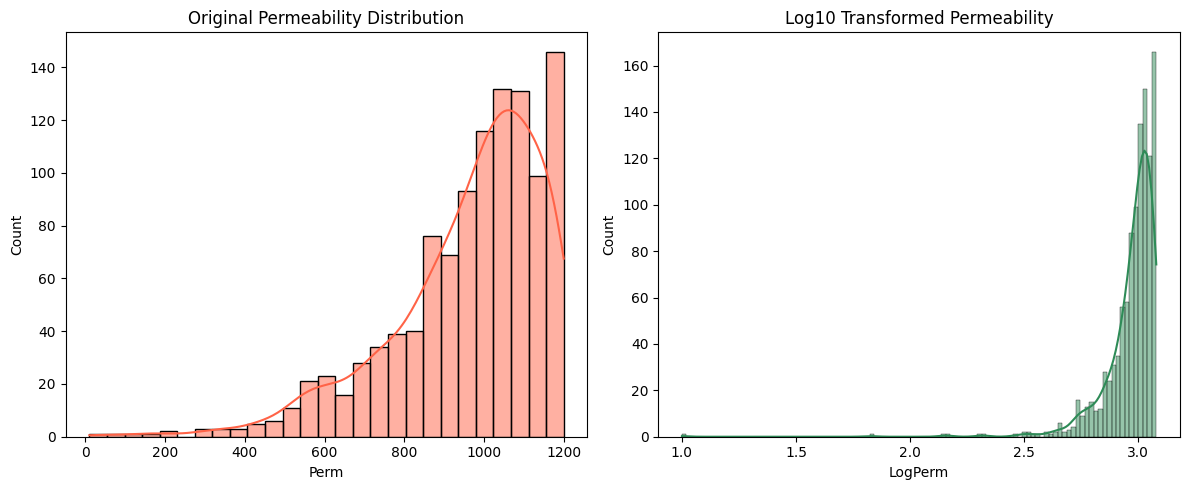

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Log-transform Perm (since it's skewed)
df['LogPerm'] = np.log10(df['Perm'])

# Step 2: Standardize Por and LogPerm
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Por', 'LogPerm']])
df_scaled = pd.DataFrame(scaled_features, columns=['Por_scaled', 'LogPerm_scaled'])
df_scaled['Facies'] = df['Facies']

# Visualization 1: Distribution of Perm and LogPerm
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Perm'], kde=True, ax=axes[0], color='tomato')
axes[0].set_title('Original Permeability Distribution')

sns.histplot(df['LogPerm'], kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('Log10 Transformed Permeability')
plt.tight_layout()
plt.show()


##### Outlier removal

Because Gaussian combination Models (GMMs) presume that the data follows a combination of Gaussian distributions that are sensitive to extreme values, outlier elimination is 

crucial.  The predicted means and covariances of the Gaussian components may be distorted by outliers, which might result in inaccurate model convergence and inadequate 

clustering.

Number of outliers detected: 13 out of 1100 samples


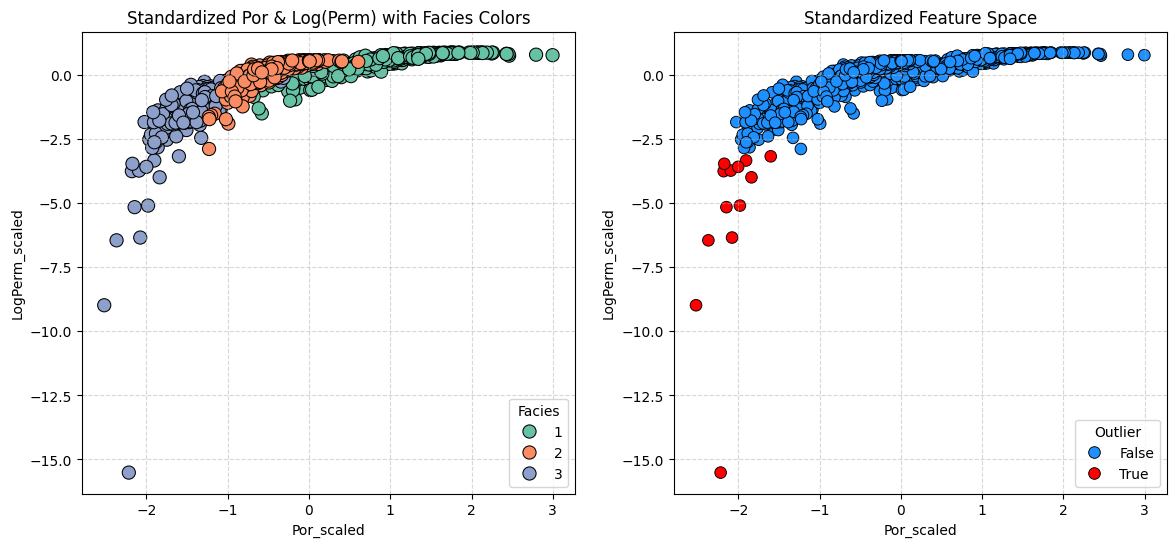

In [8]:
from scipy.stats import zscore

# --- Step 1: Compute Z-scores for Por and LogPerm ---
z_scores = zscore(df[['Por', 'LogPerm']])
outliers = np.any(np.abs(z_scores) > 3, axis=1)

# Add outlier flags to both scaled and PCA DataFrames
df_scaled['Outlier'] = outliers

# --- Step 2: Print outlier count ---
num_outliers = outliers.sum()
print(f"Number of outliers detected: {num_outliers} out of {len(df)} samples")

# --- Step 3: Combined Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# Subplot 1: Standardized Feature Space
# Visualization 2: Standardized Feature Space
sns.scatterplot(
    data=df_scaled, x='Por_scaled', y='LogPerm_scaled',
    hue='Facies', palette='Set2', s=90, edgecolor='k',
    ax=axes[0]
)

axes[0].set_title("Standardized Por & Log(Perm) with Facies Colors")
axes[0].grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(
    data=df_scaled, x='Por_scaled', y='LogPerm_scaled',
    hue='Outlier', palette={False: 'dodgerblue', True: 'red'},
    ax=axes[1], s=70, edgecolor='k'
)
axes[1].set_title("Standardized Feature Space")
axes[1].grid(True, linestyle='--', alpha=0.5)


In [9]:
df_filtered = df_scaled[df_scaled.Outlier == False]
pearson_corr_before = df_scaled.corr()['Por_scaled']['LogPerm_scaled']
pearson_corr_after = df_filtered.corr()['Por_scaled']['LogPerm_scaled']

print(f'After removing outliers, the correlation between porosity and permability improved from {pearson_corr_before:.2f} to {pearson_corr_after:.2f}')

After removing outliers, the correlation between porosity and permability improved from 0.71 to 0.83


### Application of Gaussian Mixture Model

#### Gaussian Mixture Model Clustering

A **Gaussian Mixture Model (GMM)** is a **probabilistic clustering algorithm** that assumes the data is generated from a **mixture of multiple Gaussian distributions** with unknown 

parameters. Unlike hard clustering (e.g., KMeans), GMM performs **soft clustering**, assigning each data point a probability of belonging to each cluster. It assumes data is 

generated from **Gaussian distributions** — performs poorly if not true. Always **standardize your data** before using GMM to avoid scale-related issues in covariance estimation.

For data with D features, clustering with K components is defined as:

$$
P(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

Where:

$$
\pi_k \text{ is the mixing weight of the } k^{th} \text{ component, with } \sum_{k=1}^{K} \pi_k = 1
$$

$$
\Sigma_k \text{ is the covariance matrix of the } k^{th} \text{ Gaussian}
$$

N is the multivariate normal distribution:

$$
\mathcal{N}(x \mid \mu_k, \Sigma_k) = \frac{1}{(2\pi)^{D/2} |\Sigma_k|^{1/2}} \cdot \exp\left( -\frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) \right)
$$


---

It is recommended to consider GMM when:

- Clusters are **not spherical** and may have **elliptical** shapes (✅)

- Probability scores are needed instead of strict assignments 

- **Probabilistic model** for further statistical inference is preferred

- You're clustering **multivariate continuous data** (✅)

---

GMM uses the **Expectation-Maximization (EM)** algorithm:

1. **Initialization**:
   - Choose initial values for means, covariances, and weights (via KMeans or randomly)

2. **Expectation (E-step)**:
   - Calculate the probability that each point belongs to each Gaussian component

3. **Maximization (M-step)**:
   - Update the means, covariances, and weights to maximize the **log-likelihood** of the data

4. Repeat until **convergence** (log-likelihood changes very little)


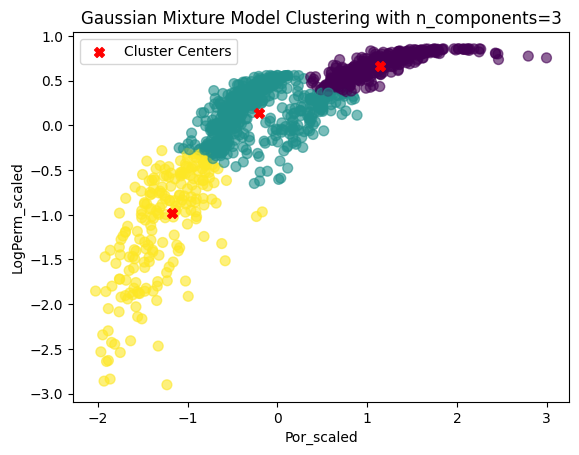

In [10]:
from sklearn.mixture import GaussianMixture

X = df_filtered[['Por_scaled', 'LogPerm_scaled']]

gmm = GaussianMixture(n_components=3)
labels = gmm.fit_predict(X)

plt.scatter(df_filtered.iloc[:, 0], df_filtered.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='X', s=50, label='Cluster Centers')

plt.title('Gaussian Mixture Model Clustering with n_components=3')
plt.xlabel('Por_scaled')
plt.ylabel('LogPerm_scaled')
plt.legend()
plt.show()

#### Evaluation Metrics - Bayesian Information Criteria


The **Bayesian Information Criterion (BIC)** is a model selection metric that balances model fit with complexity. It is commonly used to compare probabilistic models, such as 

Gaussian Mixture Models (GMM), with different numbers of components. It helps prevent overfitting by penalizing models with more parameters.

$$
\text{BIC} = -2 \cdot \ln(\hat{L}) + p \cdot \ln(n)
$$

Where:

L: the maximized value of the likelihood function of the model  

p: the number of parameters in the model  

n: the number of data points  

---

A **lower BIC value** indicates a better model. It means the model achieves a good balance between:

- Good fit (high likelihood)

- Low complexity (fewer parameters)

---

In [11]:
bic = gmm.bic(X)
print(f"BIC: {bic}")

BIC: 2846.164904135178


#### Hyperparameter Tuning
---
##### 1. `n_components`

This defines the number of Gaussian distributions (clusters) the model will try to fit.

- A higher number allows for more complex clustering but increases the risk of overfitting.

- Choosing the right value is **critical** — too small and you underfit, too large and you overfit.

- **Common approach**: Try several values and pick the one with the **lowest BIC**.

---

##### 2. `covariance_type`

This determines the shape and flexibility of each Gaussian component's distribution.

- **`full`**:  

  Each component has its own general covariance matrix ⟶ most flexible, can model any shape

- **`tied`**:  

  All components share the same general covariance matrix ⟶ faster, but less flexible

- **`diag`**:  

  Each component has its own diagonal covariance matrix ⟶ assumes features are uncorrelated, works well with high-dimensional data

- **`spherical`**:  

  Each component has its own single variance value ⟶ simplest and fastest, assumes spherical clusters


Choosing the wrong covariance type can lead to poor clustering, especially if the real data clusters have complex shapes or correlations.


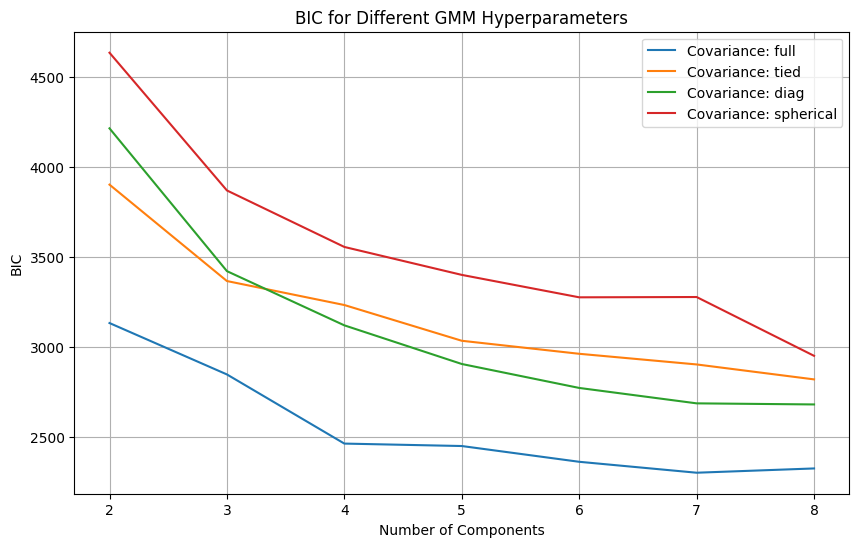

In [12]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Define the range of hyperparameters to tune (e.g., number of components)
n_components_range = range(2, 9)  # Number of components (clusters) from 2 to 8
covariance_types = ['full', 'tied', 'diag', 'spherical']  # Different covariance types
# Store BIC values for each combination of hyperparameters
bic_values = []

# Loop over the range of n_components and covariance types
for n_components in n_components_range:
    for covariance_type in covariance_types:
        # Initialize and fit the GMM model
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        gmm.fit(X)  # Assuming df_filtered is your dataset

        # Get the BIC value and store it
        bic_values.append({
            'n_components': n_components,
            'covariance_type': covariance_type,
            'bic': gmm.bic(X)
        })

# Convert the list of results to a numpy array for easy plotting and analysis
bic_df = pd.DataFrame(bic_values)

# Plot the BIC values
plt.figure(figsize=(10, 6))

# We can plot the BIC values across different configurations (e.g., different n_components and covariance types)
for covariance_type in covariance_types:
    subset = bic_df[bic_df['covariance_type'] == covariance_type]
    plt.plot(subset['n_components'], subset['bic'], label=f"Covariance: {covariance_type}")

plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC for Different GMM Hyperparameters")
plt.legend()
plt.grid()
plt.show()


As shown in the plot, the clustering method with **'covariance_type='spherical'** performs poorly in all cases based on the BIC. Since the dataset has an elliptical shape, it's expected that this approach would not work well. 

When comparing the number of components, it becomes evident that the dataset is likely to contain more than two clusters.

Overall, **'covariance_type='full'** yields better results for the clustering task. Therefore, it would be beneficial to analyze this case further with a more detailed visual examination.

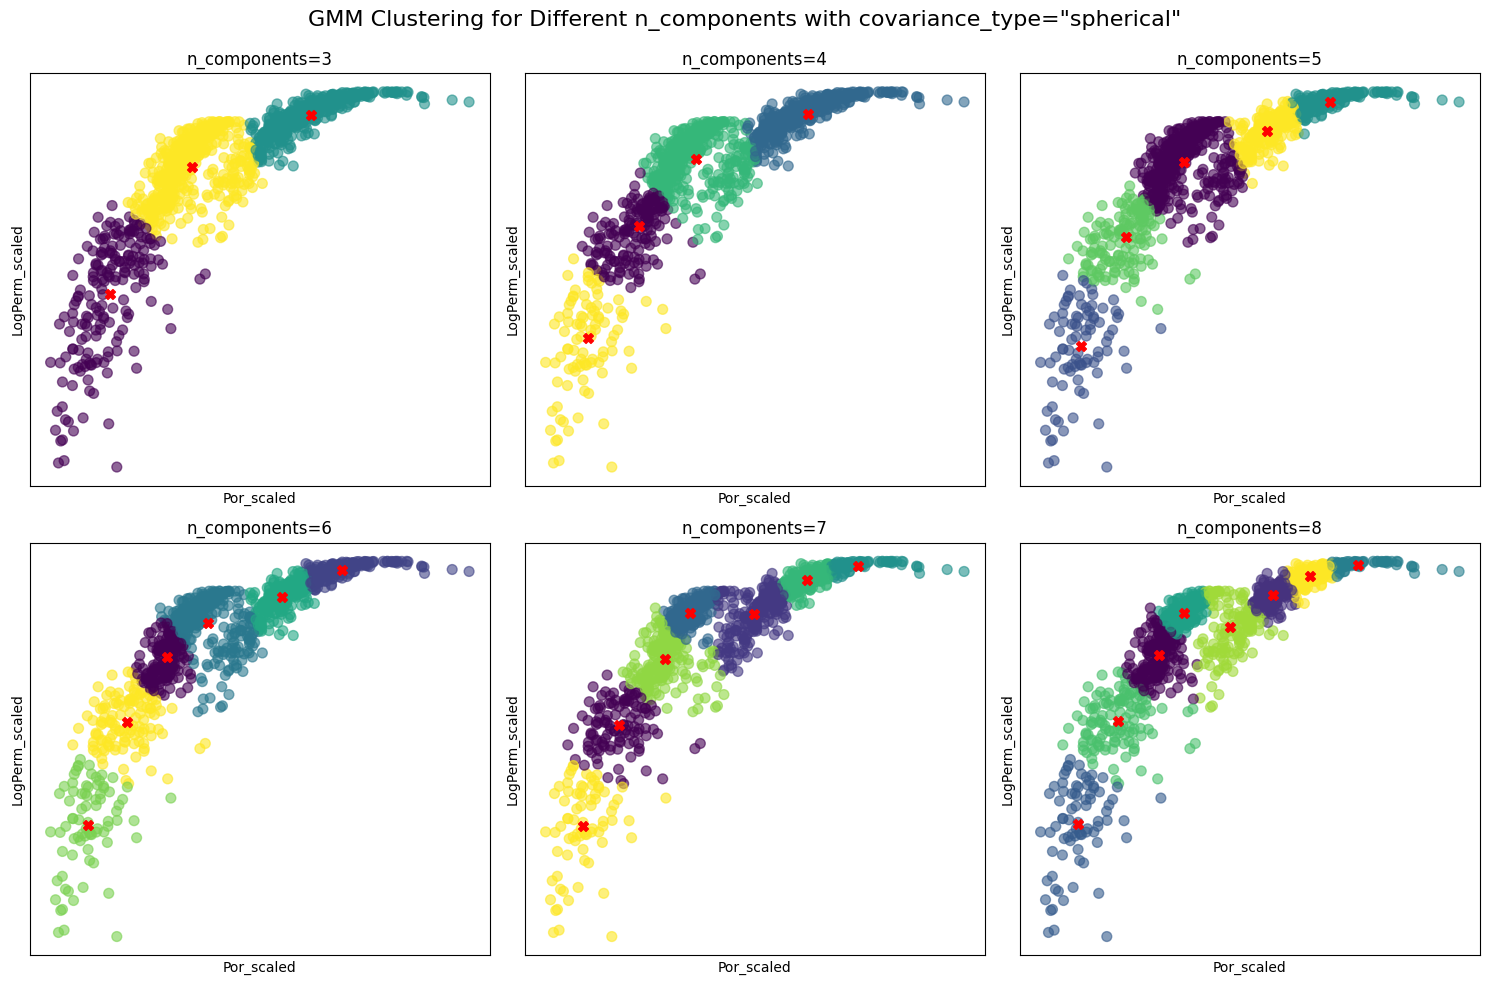

In [13]:
n_rows = 2 
n_cols = 3 

plt.figure(figsize=(15, 10))

for i in range(3, 9):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical')
    labels = gmm.fit_predict(X)

    plt.subplot(n_rows, n_cols, i - 2)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)

    # Optionally, you can also plot the cluster centers (means) of the GMM if desired
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='X', s=50, label='Cluster Centers')

    plt.title(f'n_components={i}')
    plt.xlabel('Por_scaled')  # Adjust the axis labels based on your data
    plt.ylabel('LogPerm_scaled')
    
    # Remove axis ticks for a cleaner look
    plt.xticks([])
    plt.yticks([])

plt.suptitle('GMM Clustering for Different n_components with covariance_type="spherical"', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Based on visual analysis, the clusters with **covariance_type='spherical'** appear spherical, which does not reflect the actual data distribution. This is because the spherical covariance assumption ignores certain parabolic 

and elliptical patterns present in the data.

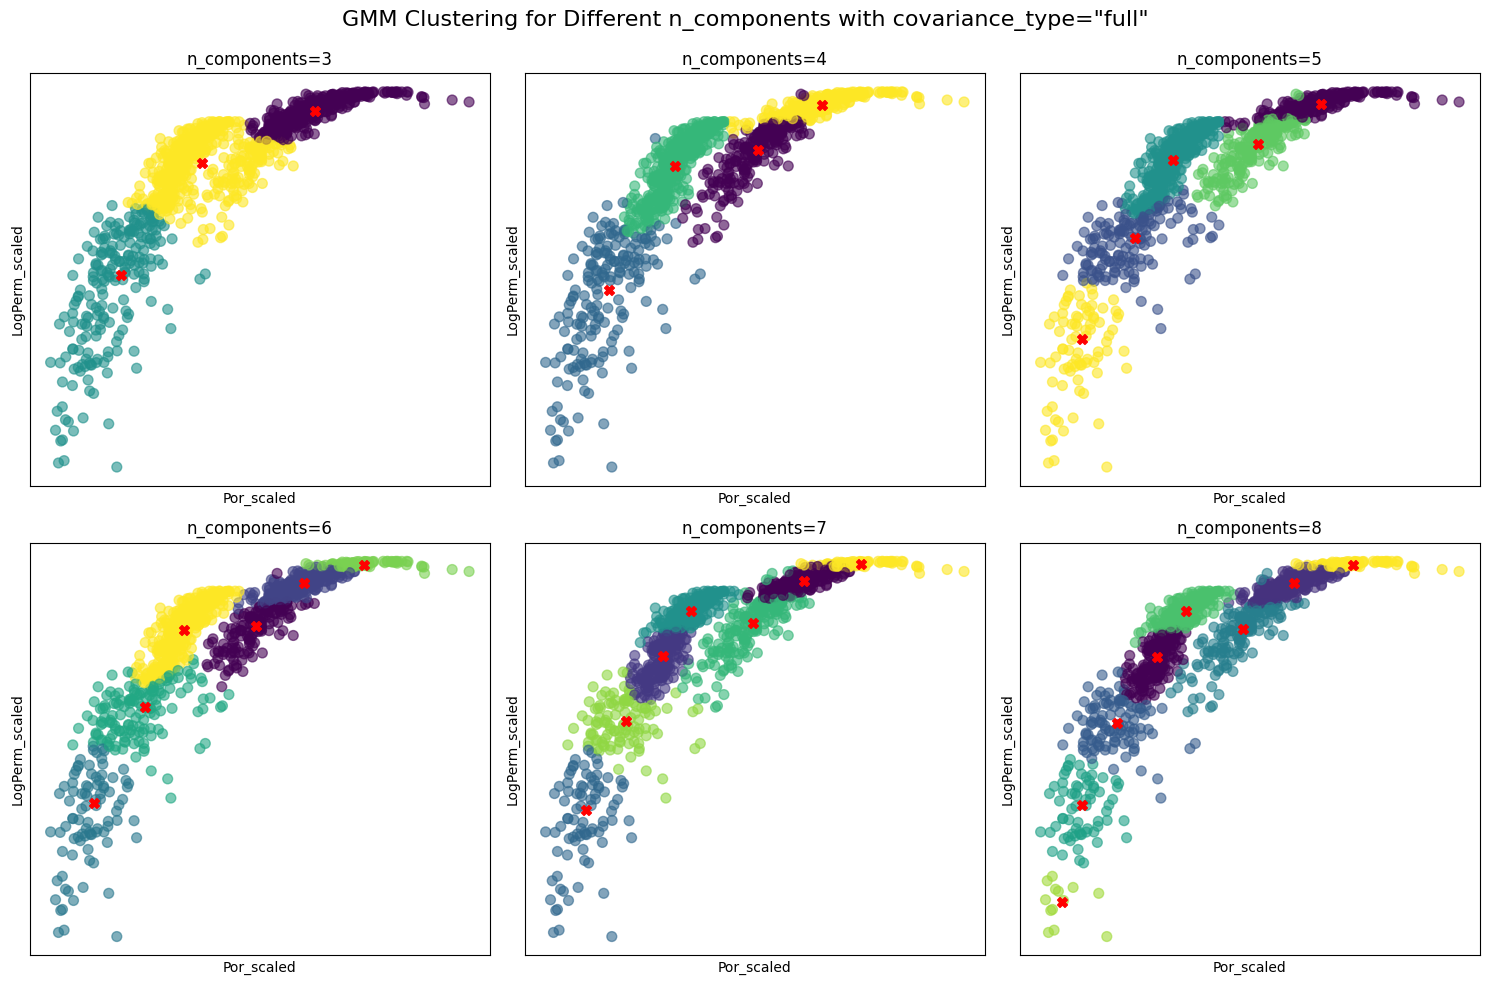

In [14]:
n_rows = 2 
n_cols = 3 

plt.figure(figsize=(15, 10))

for i in range(3, 9):
    gmm = GaussianMixture(n_components=i, covariance_type='full')
    labels = gmm.fit_predict(X)

    plt.subplot(n_rows, n_cols, i - 2)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)

    # Optionally, you can also plot the cluster centers (means) of the GMM if desired
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='X', s=50, label='Cluster Centers')

    plt.title(f'n_components={i}')
    plt.xlabel('Por_scaled')  # Adjust the axis labels based on your data
    plt.ylabel('LogPerm_scaled')
    
    # Remove axis ticks for a cleaner look
    plt.xticks([])
    plt.yticks([])

plt.suptitle('GMM Clustering for Different n_components with covariance_type="full"', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

The shapes of the clusters with **covariance_type="full"** reflect the patters better. When **`n_components >= 5`**, the model becomes harder to interpret, as the clusters are 

difficult to distinguish visually. Additionally, the improvement in the BIC value is negligible, making it not worthwhile sacrificing interpretability for a marginal gain. 

Values of 3 and 4 components are more reasonable, as they provide easily interpretable clusters. However, the model with 4 clusters gives stronger evaluation metric results.

The Gaussian Mixture Model (GMM) with 4 components and covariance_type='full' is the most effective clustering solution for this dataset. It captures the elliptical structure of 

the data while maintaining interpretability. This model will be the basis for further analysis and insights into the facies dataset, as it provides both strong performance and a 

clear, understandable representation of the underlying patterns in the data. The model with 4 clusters and a full covariance structure has been trained, and the resulting 

cluster regions are shown below.

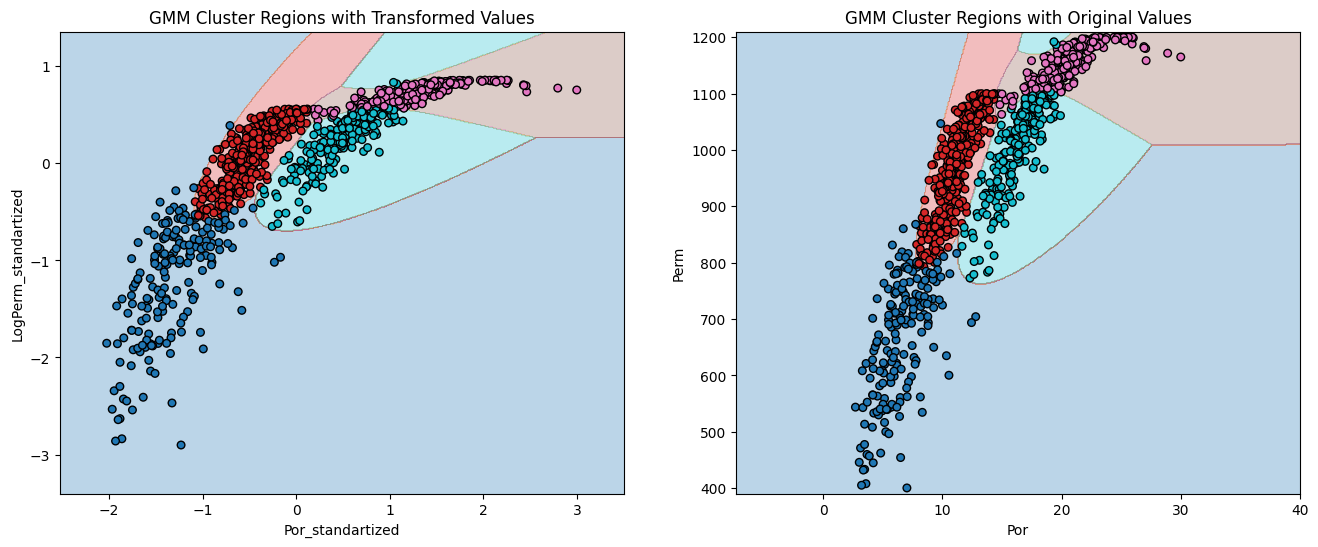

In [15]:
X_np = X.values

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm.fit(X_np)
labels = gmm.predict(X_np)

# Regions for transformed features
x = np.linspace(X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5, 500)
y = np.linspace(X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5, 500)
X_grid_transformed, Y_grid_transformed = np.meshgrid(x, y)
XY = np.column_stack([X_grid_transformed.ravel(), Y_grid_transformed.ravel()])
Z_transformed = gmm.predict(XY)
Z_transformed = Z_transformed.reshape(X_grid_transformed.shape)

# Regions for original features
X_original = df[df_scaled.Outlier == False][['Por', 'Perm']].values
x = np.linspace(X_original[:, 0].min() - 10, X_original[:, 0].max() + 10, 500)
y = np.linspace(X_original[:, 1].min() - 10, X_original[:, 1].max() + 10, 500)
X_grid_original, Y_grid_original = np.meshgrid(x, y)
XY = np.column_stack([X_grid_original.ravel(), Y_grid_original.ravel()])

df_xy = pd.DataFrame({
    'X': X_grid_original.ravel(),  
    'Y': Y_grid_original.ravel() 
})

df_xy['Y'] = np.log10(df_xy['Y'])
df_xy = scaler.transform(df_xy)
Z_original = gmm.predict(df_xy)
Z_original = Z_original.reshape(X_grid_original.shape)

# Step 3: Plot cluster regions and data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].contourf(X_grid_transformed, Y_grid_transformed, Z_transformed, alpha=0.3, cmap='tab10')  # Cluster regions
axes[0].scatter(X_np[:, 0], X_np[:, 1], c=labels, s=30, cmap='tab10', edgecolor='k')
axes[0].set_title("GMM Cluster Regions with Transformed Values")
axes[0].set_xlabel("Por_standartized")
axes[0].set_ylabel("LogPerm_standartized")

axes[1].contourf(X_grid_original, Y_grid_original, Z_original, alpha=0.3, cmap='tab10')  # Cluster regions
axes[1].scatter(X_original[:, 0], X_original[:, 1], c=labels, s=30, cmap='tab10', edgecolor='k')
axes[1].set_title("GMM Cluster Regions with Original Values")
axes[1].set_xlabel("Por")
axes[1].set_ylabel("Perm")

plt.show()

Interestingly, in some cases (e.x. green and purple points in n_components=4), a cluster is surrounded or divided by another cluster. It occurs because Gaussian Mixture Models 

use soft clustering, where each point is assigned a probability of belonging to multiple clusters. Since the clusters have elliptical shapes and overlap, some points near the 

boundary have a non-zero probability of belonging to the neighbor cluster as well. The covariance_type='full' setting allows for complex, non-spherical shapes, which further 

facilitates this overlap. As a result, the points in the overlapping region are assigned probability across both clusters, leading to the division of points into the neighbor 

region.

### Summary

Gaussian Mixture Models (GMM) are particularly effective for clustering data with elliptical or non-spherical shapes, offering key advantages over traditional distance-based 

methods like k-means. One of the most important strengths of GMM lies in its ability to model the full covariance of each cluster, allowing it to capture not just the size but 

also the orientation and shape of the data distribution. This flexibility means clusters can take on elliptical, tilted, or otherwise complex forms that better reflect 

real-world data patterns. Additionally, GMM uses soft clustering, assigning each data point a probability of belonging to multiple clusters. This probabilistic approach is 

especially useful in regions where clusters overlap or boundaries are ambiguous, as it avoids the rigid, all-or-nothing assignments seen in k-means. In contrast, distance-based 

methods assume spherical clusters of equal variances and assign each point to a single cluster based on proximity.

### References

1. GaussianMixture [https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html]

2. In Depth: Gaussian Mixture Models [https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html]